### Imports, config and installations

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

In [7]:
sns.set_style('darkgrid')
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (20, 10)

In [8]:
!pip install calmap

You should consider upgrading via the '/Users/akarajgi/opt/anaconda3/envs/chatbot_2_6_2/bin/python -m pip install --upgrade pip' command.


In [9]:
import calmap

### The Dataset
The dataset contains birth data for 2000-2014 and 1994-2003. We'll be using 2000-2014 birth data for this.

If you're interested in using the other file or the entire dataset, please make sure to download the `births` dataset from https://data.fivethirtyeight.com/ and place is in this directory before running the notebook.



In [10]:
df = pd.read_csv('US_births_2000-2014_SSA.csv')

In [11]:
df.head()

,year,month,date_of_month,day_of_week,births
0,2000,1,1,6,9083
1,2000,1,2,7,8006
2,2000,1,3,1,11363
3,2000,1,4,2,13032
4,2000,1,5,3,12558


#### Pre-processing

In [12]:
df = df.drop('day_of_week', axis=1)

In [13]:
df = df.rename({"date_of_month": "day"}, axis=1)

In [14]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.drop(['year', 'month', 'day'], axis=1)

In [15]:
df.isna().sum()

births    0
date      0
dtype: int64

#### 2014 calendar heatmap

In [16]:
df_14 = df[df['date'].dt.year == 2014]

In [17]:
df_dates_14 = pd.Series(df_14['births'])
df_dates_14.index = df_14['date']

In [18]:
df_dates_14

date
2014-01-01     8018
2014-01-02    11171
2014-01-03    12317
2014-01-04     8199
2014-01-05     7174
              ...  
2014-12-27     8656
2014-12-28     7724
2014-12-29    12811
2014-12-30    13634
2014-12-31    11990
Name: births, Length: 365, dtype: int64

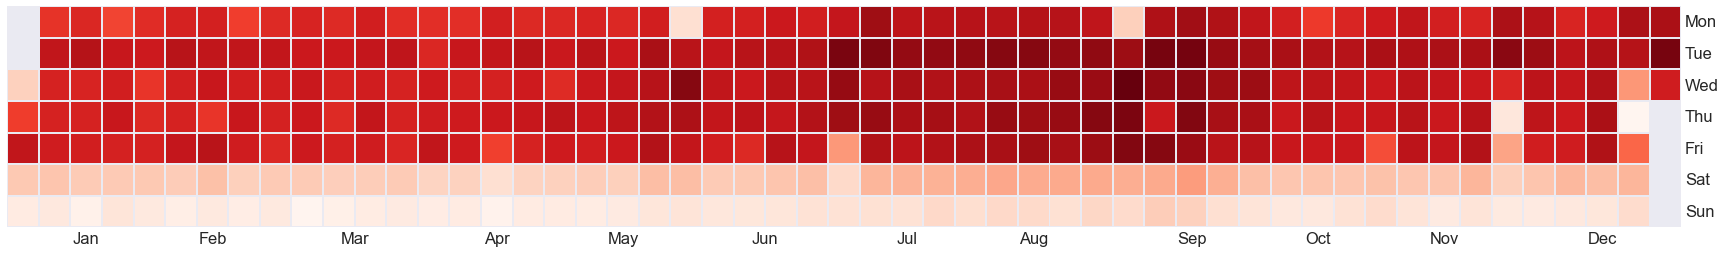

In [19]:
plt.figure(figsize=(30, 10))
_ = calmap.yearplot(df_dates_14)

The calendar heatmap above confirms a lot of what we expected:
- more births near September (American birth pattern)
- less births on the weekends
- less births on public holidays

This proves that the uniformity assumption doesn't hold. Let's now run a few experiments to better understand this.

### Experiments

#### The utility function
Let's first create a utility function that accepts:
- a data frame
- a sample size
- number of such samples to test on
- a flag to trigger uniformity

At a high level, this function simply creates multiple samples of a given sample size from our data frame and checks if that sample has a birthday match or not. It then returns the fraction of these samples that had a match.

In [20]:
def get_prob(df, sample_size=23, num_samples=10, uniform=False):
    is_dup = 0
    pbar = trange(num_samples)

    if uniform:
        weights = None
    else:
        weights = 'births'

    for _ in pbar:
        sample = df.sample(n=sample_size, replace=True, weights=weights)['date']
        if sample.duplicated().any():
            is_dup += 1
        
        pbar.set_description("matches: {}/{}".format(is_dup, num_samples))

    return is_dup / num_samples

#### A simple example

In [21]:
get_prob(df_14, num_samples=1000)

matches: 548/1000: 100%|██████████| 1000/1000 [00:03<00:00, 282.62it/s]


0.548

#### Trends over the number of samples

In [22]:
NUMBER_OF_SAMPLES = [1, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000]

In [23]:
probs = []
for i in NUMBER_OF_SAMPLES:
    probs.append(get_prob(df_14, num_samples=i))

matches: 1561/3000: 100%|██████████| 3000/3000 [00:11<00:00, 265.61it/s]


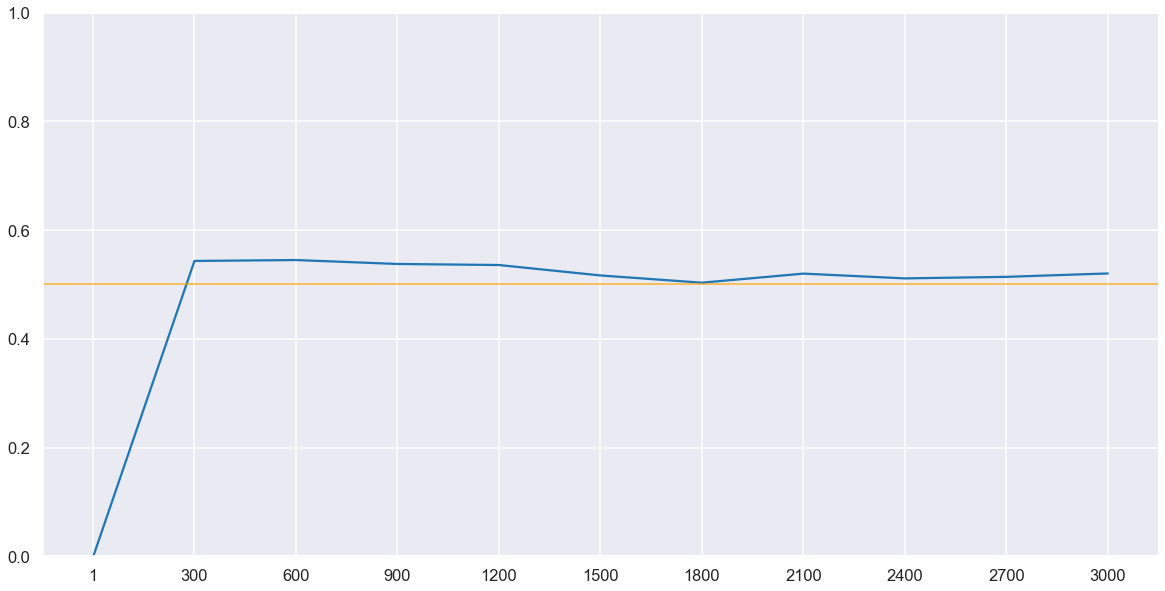

In [24]:
_ = sns.lineplot(x=NUMBER_OF_SAMPLES, y=probs)
_ = plt.ylim(0, 1)
_ = plt.xticks(NUMBER_OF_SAMPLES)
_ = plt.axhline(0.5, linewidth=2, label="mean", alpha=0.6, color='orange')

As expected, we expect more consistent results over more data. Let's go with 2000 samples, since the plot has fairly converged at that point.

#### Trends over the sample size
In this experiment, we'll vary the sample size for a fixed number of samples (2000) with and without the uniformity assumption.

We expect a probability of a little over 0.5 when the sample size is 23.

##### Without the uniformity assumption

In [25]:
SAMPLE_SIZE = [1, 10, 20, 23, 30, 40, 50, 60, 70, 80, 90]

In [34]:
probs_n = []
for n in SAMPLE_SIZE:
    probs_n.append(get_prob(df_14, sample_size=n, num_samples=2000))

matches: 2000/2000: 100%|██████████| 2000/2000 [00:13<00:00, 151.46it/s]


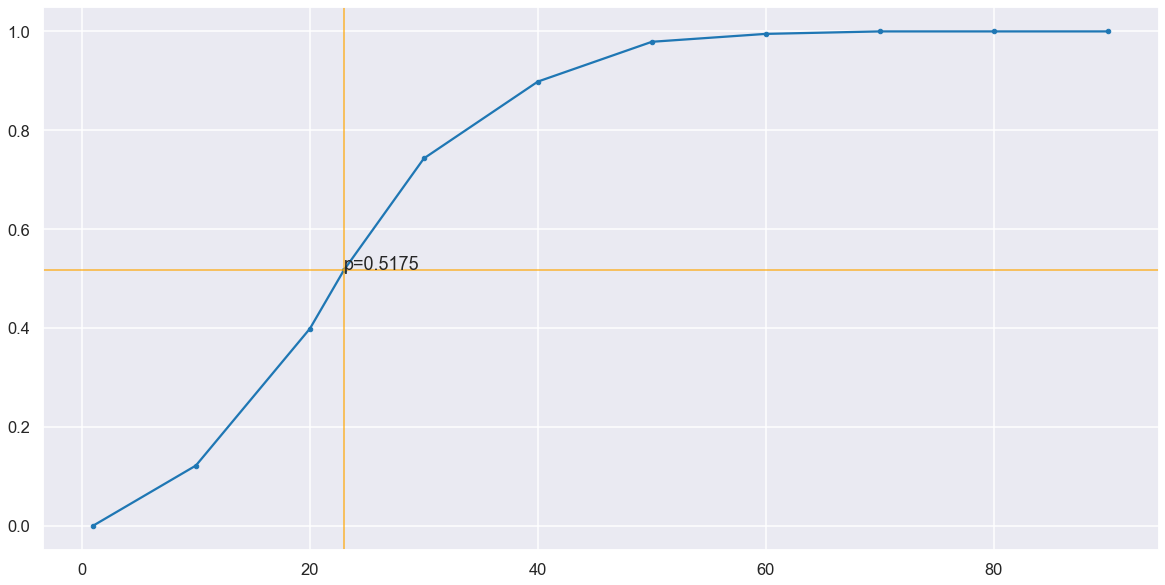

In [35]:
_ = plt.plot(SAMPLE_SIZE, probs_n, '.-')
_ = plt.axvline(23, linewidth=2, label="mean", alpha=0.6, color='orange')
_ = plt.axhline(probs_n[3], linewidth=2, label="mean", alpha=0.6, color='orange')
_ = plt.text(23, probs_n[3],"p={}".format(probs_n[3]))

##### With the uniformity assumption

In [36]:
probs_n_uniform = []
for n in SAMPLE_SIZE:
    probs_n_uniform.append(get_prob(df_14, sample_size=n, num_samples=2000, uniform=True))

matches: 2000/2000: 100%|██████████| 2000/2000 [00:09<00:00, 221.55it/s]


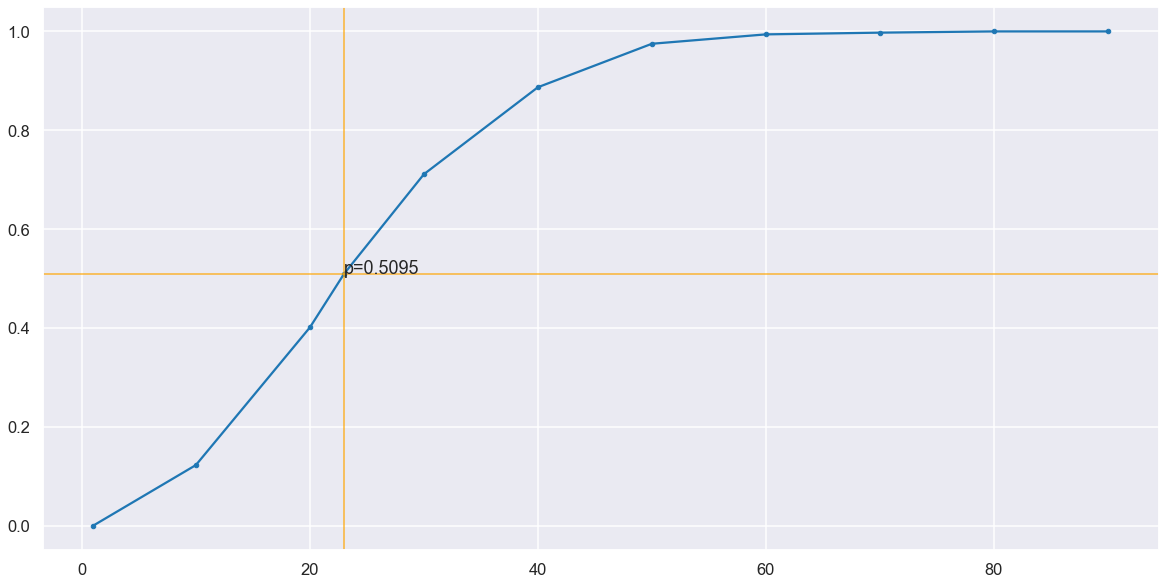

In [37]:
_ = plt.plot(SAMPLE_SIZE, probs_n_uniform, '.-')
_ = plt.axvline(23, linewidth=2, label="mean", alpha=0.6, color='orange')
_ = plt.axhline(probs_n_uniform[3], linewidth=2, label="mean", alpha=0.6, color='orange')
_ = plt.text(23, probs_n_uniform[3],"p={}".format(probs_n_uniform[3]))

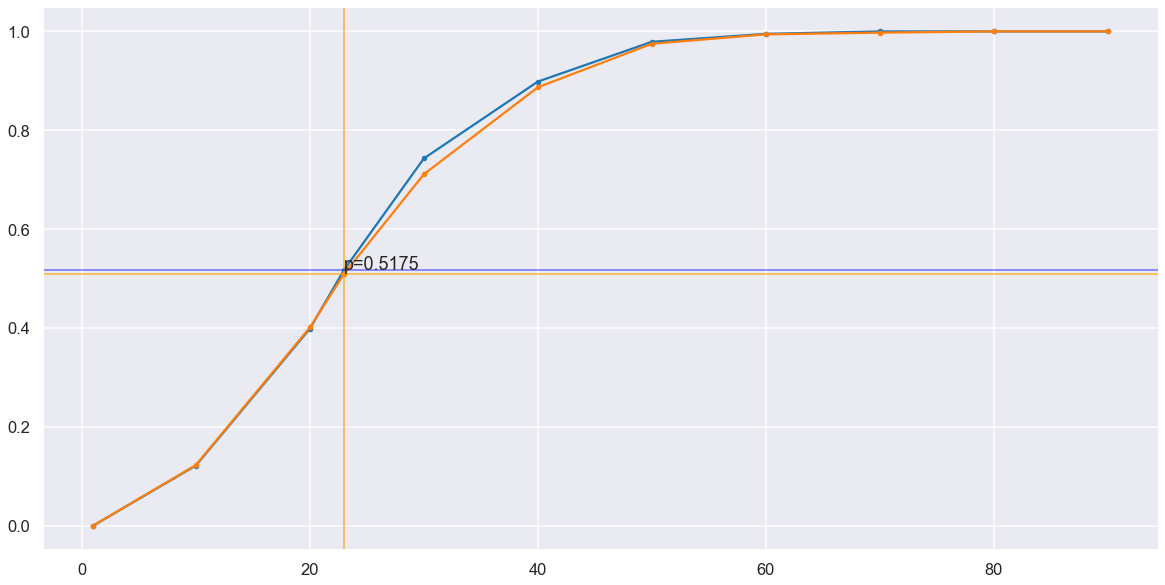

In [38]:
_ = plt.plot(SAMPLE_SIZE, probs_n, '.-')
_ = plt.plot(SAMPLE_SIZE, probs_n_uniform, '.-')
_ = plt.axvline(23, linewidth=2, label="mean", alpha=0.6, color='orange')
_ = plt.axhline(probs_n[3], linewidth=2, label="mean", alpha=0.4, color='blue')
_ = plt.axhline(probs_n_uniform[3], linewidth=2, label="mean", alpha=0.6, color='orange')
_ = plt.text(23, probs_n[3],"p={}".format(probs_n[3]))

Its very similar to the values we got when we didn't have the uniformity assumption. The key point here is that for n = 23, we got a slightly lower value with the uniformity assumption than without it.

This is consistent with the intuition that its more likely for two people to have the same birthday if some dates are more likely than others.

Of course, due to the randomness involved in creating those 2000 samples, its possible for this to occasionally not hold true, but that's unlikely.

#### Trends over the years
For a sample size of 23 and 2000 samples, let's calculate the fraction of samples where there's a birthday match.

##### Calculating probabilities without the uniformity assumption

In [31]:
probs_years = []
for i in range(2000, 2015):
    probs_years.append(get_prob(df[df['date'].dt.year == i], num_samples=2000))

matches: 1002/2000: 100%|██████████| 2000/2000 [00:10<00:00, 185.87it/s]


##### Calculating probabilities with the uniformity assumption

In [32]:
probs_years_uniform = []
for i in range(2000, 2015):
    probs_years_uniform.append(get_prob(df[df['date'].dt.year == i], num_samples=2000, uniform=True))

matches: 1018/2000: 100%|██████████| 2000/2000 [00:09<00:00, 207.92it/s]


##### Plotting the results

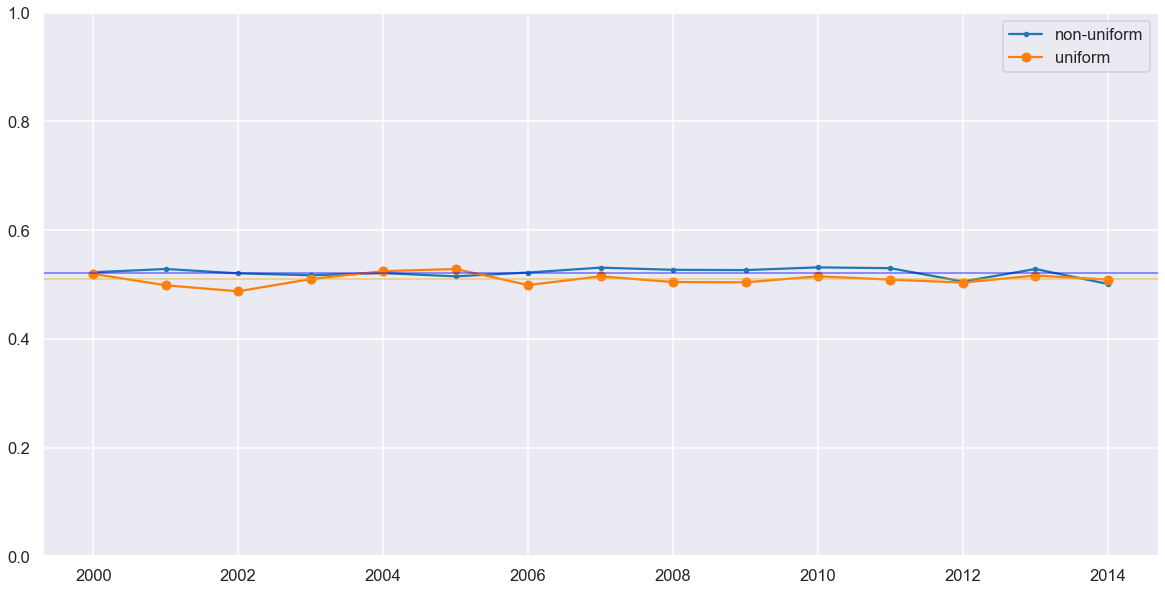

In [33]:
_ = plt.plot(range(2000, 2015), probs_years, '.-')
_ = plt.plot(range(2000, 2015), probs_years_uniform, 'o-')
_ = plt.legend(("non-uniform", "uniform"))
_ = plt.axhline(np.mean(probs_years), linewidth=2, label="mean", alpha=0.4, color='blue')
_ = plt.axhline(np.mean(probs_years_uniform), linewidth=2, label="mean", alpha=0.4, color='orange')
_ = plt.ylim(0, 1)

### Conclusion
We conducted a few experiments to understand this paradox better and what the trends look like by varying the number of samples we choose, the years we select and the sample size itself. Of course, a few more experiments can be conducted, which I may get to in some time:
- running the experiment by averaging over all years from 2000-2014
- running the experiment on data from 1994 to 2003
- analyzing the difference in trends between the two year ranges
- analyzing trends on a weekly basis and how it changed over the years